<a href="https://colab.research.google.com/github/ccosmin97/idc-prostate-mri-analysis/blob/main/results_bq_qin_prostate_repeatability_analysis_gt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Not meant to be run cell by cell -- need user permissions to google cloud big queries

#Authentification

In [ ]:
#colab 
from google.colab import auth
auth.authenticate_user()

## Setup GCP Project ID

In [ ]:
project_id = "idc-sandbox-003" # #YOUR_PROJECT ID

# Imports

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import datetime
import seaborn as sns


from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import Legend, LegendItem

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.palettes import brewer

output_notebook()

# Custom functions

In [ ]:
def calculate_time_index(row, df_input): #assumes only two studies per PatientID
  other_study_time = df_input[(df_input["PatientID"] == row["PatientID"]) 
    & (df_input["StudyInstanceUID"] != row["StudyInstanceUID"])].study_date.values[0]
  if row.study_date < other_study_time:
    return "T0"
  elif row.study_date > other_study_time:
    return "T1"
  else:
    return "T"

In [ ]:
def add_ohif_url_prostate(row):
    studyUID = row['StudyInstanceUID']
    return "https://fir-idc-prostate-ohif.web.app/projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/prostatex_datastore/study/"+studyUID

In [ ]:
def add_ohif_url_pz_tz(row):
    studyUID = row['StudyInstanceUID']
    return "https://fir-idc-prostate-ohif.web.app/projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/prostatex_no_gt_datastore/study/"+studyUID

In [ ]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
         
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                 
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    colors = ["#ff0000", "#04b404", "#f7fe2e"]#brewer["Spectral"][len(df[treatment_col].unique())]
 
    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}
 
    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

# Query nnunet prediction results

Query BigQuery table containing metadata about nnunet segmentations for **peripheral zone -- transition zone structures**

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project_id)
selection_query = f"""
  SELECT  
  *
FROM 
  `idc-sandbox-003.qin_prostate_repeatability.pz_tz_dcm` """

In [ ]:
selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

Query BigQuery table containing metadata about nnunet segmentations for **whole prostate gland**

In [ ]:
selection_query = f"""
  SELECT  
  *
FROM 
  `idc-sandbox-003.qin_prostate_repeatability.whole_prostate_dcm` """
selection_result = bq_client.query(selection_query)
selection_prostate_df = selection_result.result().to_dataframe()

## metadata pre-processing of dfs

### peripheral/transition zone segments

In [ ]:
unique_patIDS_no_labels = selection_df[selection_df["PZ_RefSerieUID"].isna()].patientID.unique()
unique_patIDS_with_labels = selection_df[selection_df["PZ_RefSerieUID"].notna()].patientID.unique()
print(f"patientIDs with no ground truth segs for PZ and TZ structures : {len(unique_patIDS_no_labels)}")
print(f"patientIDs with ground truth segs for PZ and TZ structures : {len(unique_patIDS_with_labels)}")

patientIDs with no ground truth segs for PZ and TZ structures : 0
patientIDs with ground truth segs for PZ and TZ structures : 15


Select PZ segments wihtout empty rows

In [ ]:
gt_selection_df = selection_df[selection_df["PZ_RefSerieUID"].notna()]

Selection of DCM metadata only 

In [ ]:
#PZ
gt_pz_selection_df = gt_selection_df.loc[:, ['ReferencedSeriesInstanceUID', 'StudyInstanceUID', 'patientID',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesInstanceUID', 'Modality',
       'SeriesDescription', 'studydesc', 'series_time', 'study_time',
       'series_date', 'study_date', 'ohif_url', 'cloud_storage_path'] \
  +list(gt_selection_df.filter(regex=("PZ.*"),axis=1).columns.values)]

gt_pz_selection_df.columns = gt_pz_selection_df.columns.str.replace('PZ_', '')
gt_pz_selection_df["regions"] = gt_pz_selection_df.apply(lambda x : "PZ" ,axis=1)
gt_pz_selection_df = gt_pz_selection_df.reset_index(drop=True)

In [ ]:
# df_all = pd.concat([gt_pz_selection_df, gt_tz_selection_df])

### Whole Prostate segment -- same process

In [ ]:
unique_patIDS_no_labels = selection_prostate_df[selection_prostate_df["PROSTATE_RefSerieUID"].isna()].patientID.unique()
unique_patIDS_with_labels = selection_prostate_df[selection_prostate_df["PROSTATE_RefSerieUID"].notna()].patientID.unique()
print(f"patientIDs with no ground truth segs for PZ and TZ structures : {len(unique_patIDS_no_labels)}")
print(f"patientIDs with ground truth segs for PZ and TZ structures : {len(unique_patIDS_with_labels)}")

patientIDs with no ground truth segs for PZ and TZ structures : 0
patientIDs with ground truth segs for PZ and TZ structures : 15


In [ ]:
#PZ
cleaned_prostate_df = selection_prostate_df.loc[:, ['ReferencedSeriesInstanceUID', 'StudyInstanceUID', 'patientID',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesInstanceUID', 'Modality',
       'SeriesDescription', 'studydesc', 'series_time', 'study_time',
       'series_date', 'study_date', 'ohif_url', 'cloud_storage_path'] \
  +list(selection_prostate_df.filter(regex=("PROSTATE.*"),axis=1).columns.values)]

cleaned_prostate_df.columns = cleaned_prostate_df.columns.str.replace('PROSTATE_', '')
cleaned_prostate_df["regions"] = cleaned_prostate_df.apply(lambda x : "Prostate" ,axis=1)
cleaned_prostate_df = cleaned_prostate_df.reset_index(drop=True)

Merge processed PZ/TZ and whole prostate dataframe

In [ ]:
df_all = pd.concat([gt_pz_selection_df, cleaned_prostate_df])

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 29
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ReferencedSeriesInstanceUID  60 non-null     object 
 1   StudyInstanceUID             60 non-null     object 
 2   patientID                    60 non-null     object 
 3   SOPClassUID                  60 non-null     object 
 4   SOPInstanceUID               60 non-null     object 
 5   SeriesInstanceUID            60 non-null     object 
 6   Modality                     60 non-null     object 
 7   SeriesDescription            60 non-null     object 
 8   studydesc                    60 non-null     object 
 9   series_time                  60 non-null     object 
 10  study_time                   60 non-null     object 
 11  series_date                  60 non-null     object 
 12  study_date                   60 non-null     object 
 13  ohif_url              

In [ ]:
df_all.sort_values('dice_score')[["dice_score", "SeriesInstanceUID", "PatientID"]].head()

,dice_score,SeriesInstanceUID,PatientID
8,0.000000,1.2.276.0.7230010.3.1.3.481034752.5602.1666822...,PCAMPMRI-00012
9,0.000000,1.2.276.0.7230010.3.1.3.481034752.5593.1666822...,PCAMPMRI-00012
24,0.058837,1.2.276.0.7230010.3.1.3.481034752.5647.1666822...,PCAMPMRI-00005
15,0.157301,1.2.276.0.7230010.3.1.3.481034752.5599.1666822...,PCAMPMRI-00015
14,0.171580,1.2.276.0.7230010.3.1.3.481034752.5611.1666822...,PCAMPMRI-00015


# Visualization of results

## Dice score

In [ ]:
# Get a color for each region 
colormap, colors = color_list_generator(df_all, 'regions')
df_all['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions)) 

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(dice_score)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_all.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           # x_range=cats, 
           title="Dice score of nnUNet predictions per label")

p.circle(y='dice_score', x=jitter('regions', width=0.6, range=p.x_range), source=df_all, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_all['regions'] = df_all['regions'].astype(category_region)

groups = df_all.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr#groups.max()#q3 + 1.5*iqr
lower = q1 - 1.5*iqr#groups.min()#q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.dice_score,
    top=q3.dice_score,
    fill_color=colors,
    legend=cats
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.dice_score,
    top=q2.dice_score,
    fill_color=colors
))
 
 
# p = figure(tools="save", title="", x_range=df_plot.regions.unique())
 
# stems (Don't need colors of treatment)
p.segment(cats, upper.dice_score, cats, q3.dice_score, line_color="black")
p.segment(cats, lower.dice_score, cats, q1.dice_score, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.dice_score, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.dice_score, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
 
p.add_layout(legend, 'below')    
 
# Setup plot titles and such.
p.title.text = "dice_score of nnUNet predictions per label"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="label"
p.yaxis.axis_label="dice_score"
p.legend.location = (100,10)
 
# show(p)
########
# p.legend.visible=False 

url="@ohif_url"#SeriesInstanceUID"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

colormap: {'PZ': '#ff0000', 'Prostate': '#04b404'}
colormap_list_keys: ['PZ', 'Prostate']
regions: ['PZ', 'Prostate']
colors: ['#ff0000', '#04b404']
cats: ['PZ' 'Prostate']
regions: ['PZ', 'Prostate']


<ipython-input-102-768a927d9830>:49: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

<ipython-input-102-768a927d9830>:50: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

<ipython-input-102-768a927d9830>:51: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.



## Hausdorff distance

In [ ]:
# Get a color for each region 
colormap, colors = color_list_generator(df_all, 'regions')
df_all['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions)) 

# Get a list of unique colors that match the order of the regions
# num_colors = len(list(set(colors)))
# colors = [] 
# for n in range(0,num_colors):
#   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   colors.append(c)

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(hausdorff_dist)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_all.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           # x_range=cats, 
           title="hausdorff_dist of nnUNet predictions per label")

p.circle(y='hausdorff_dist', x=jitter('regions', width=0.6, range=p.x_range), source=df_all, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_all['regions'] = df_all['regions'].astype(category_region)

groups = df_all.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.hausdorff_dist,
    top=q3.hausdorff_dist,
    fill_color=colors,
    legend=cats
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.hausdorff_dist,
    top=q2.hausdorff_dist,
    fill_color=colors
))
 
 
# p = figure(tools="save", title="", x_range=df_plot.regions.unique())
 
# stems (Don't need colors of treatment)
p.segment(cats, upper.hausdorff_dist, cats, q3.hausdorff_dist, line_color="black")
p.segment(cats, lower.hausdorff_dist, cats, q1.hausdorff_dist, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.hausdorff_dist, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.hausdorff_dist, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
 
p.add_layout(legend, 'below')    
 
# Setup plot titles and such.
p.title.text = "Hausdorff distance of nnUNet predictions per label"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="label"
p.yaxis.axis_label="hausdorff_dist"
p.legend.location = (100,10)
 
# show(p)
########
# p.legend.visible=False 

url="@ohif_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

colormap: {'PZ': '#ff0000', 'Prostate': '#04b404'}
colormap_list_keys: ['PZ', 'Prostate']
regions: ['PZ', 'Prostate']
colors: ['#ff0000', '#04b404']
cats: ['PZ', 'Prostate']
Categories (2, object): ['PZ' < 'Prostate']
regions: ['PZ', 'Prostate']


<ipython-input-103-1661755805db>:49: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

<ipython-input-103-1661755805db>:50: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

<ipython-input-103-1661755805db>:51: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.



## Regression plots

### PZ - hausdorff dist against dice_score

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



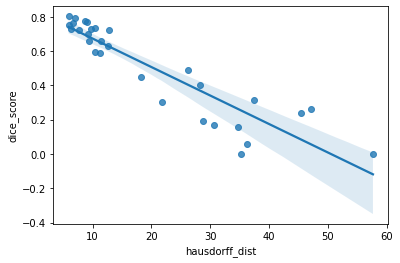

In [ ]:
# ax=gt_pz_selection_df.plot.scatter(x='hausdorff_dist', y='dice_score')
# gt_pz_selection_df.plot(x='hausdorff_dist',y='dice_score',legend=True,ax=ax)
sns.regplot(gt_pz_selection_df['hausdorff_dist'],gt_pz_selection_df['dice_score'])

In [ ]:
print(f"Qin-Prostate-Repeatability : Average dice score for Peripheral Zone : {round(np.average(df_all[df_all.regions == 'PZ'].dice_score), 2)}")
print(f"Qin-Prostate-Repeatability : Average dice score for Whole Prostate Gland : {round(np.average(df_all[df_all.regions == 'Prostate'].dice_score), 2)}")

Qin-Prostate-Repeatability : Average dice score for Peripheral Zone : 0.51
Qin-Prostate-Repeatability : Average dice score for Whole Prostate Gland : 0.85


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 29
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ReferencedSeriesInstanceUID  60 non-null     object  
 1   StudyInstanceUID             60 non-null     object  
 2   patientID                    60 non-null     object  
 3   SOPClassUID                  60 non-null     object  
 4   SOPInstanceUID               60 non-null     object  
 5   SeriesInstanceUID            60 non-null     object  
 6   Modality                     60 non-null     object  
 7   SeriesDescription            60 non-null     object  
 8   studydesc                    60 non-null     object  
 9   series_time                  60 non-null     object  
 10  study_time                   60 non-null     object  
 11  series_date                  60 non-null     object  
 12  study_date                   60 non-null     object  
 13  ohif_ur

In [ ]:
df_all[df_all.StudyInstanceUID == '1.3.6.1.4.1.14519.5.2.1.3671.4754.298665348758363466150039312520'][['dice_score', 'center_mass_pred', 'center_mass_ref', 'hausdorff_dist', 'segment', 'patientID']]

,dice_score,center_mass_pred,center_mass_ref,hausdorff_dist,segment,patientID
9,0.000000,-31.2915 -15.0526 14.7528,-24.0031 39.1036 16.9828,57.671757,PZ,PCAMPMRI-00012
8,0.872965,-27.6816 20.3551 11.8506,-27.8739 21.6619 10.6853,14.000000,prostate,PCAMPMRI-00012


In [ ]:
df_all[df_all.patientID == 'PCAMPMRI-00014'][['dice_score', 'center_mass_pred', 'center_mass_ref', 'hausdorff_dist', 'segment', 'patientID', 'StudyInstanceUID']]

,dice_score,center_mass_pred,center_mass_ref,hausdorff_dist,segment,patientID,StudyInstanceUID
12,0.490590,-53.7418 25.8729 -79.3568,-39.5494 26.6038 -75.5417,26.250898,PZ,PCAMPMRI-00014,1.3.6.1.4.1.14519.5.2.1.3671.4754.288453744990...
13,0.723094,15.4246 31.8179 -14.178,15.7361 32.1181 -12.1905,7.698456,PZ,PCAMPMRI-00014,1.3.6.1.4.1.14519.5.2.1.3671.4754.194890890650...
12,0.722186,15.0926 27.6339 -9.18437,15.4043 29.1591 -13.3879,14.000000,prostate,PCAMPMRI-00014,1.3.6.1.4.1.14519.5.2.1.3671.4754.194890890650...
13,0.801746,-39.1348 21.4024 -74.4854,-38.7469 23.4971 -76.3126,8.716873,prostate,PCAMPMRI-00014,1.3.6.1.4.1.14519.5.2.1.3671.4754.288453744990...


## Evolution of dice score between time points -- nnUnet preds vs GT -- Whole prostate gland

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 29
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ReferencedSeriesInstanceUID  60 non-null     object  
 1   StudyInstanceUID             60 non-null     object  
 2   patientID                    60 non-null     object  
 3   SOPClassUID                  60 non-null     object  
 4   SOPInstanceUID               60 non-null     object  
 5   SeriesInstanceUID            60 non-null     object  
 6   Modality                     60 non-null     object  
 7   SeriesDescription            60 non-null     object  
 8   studydesc                    60 non-null     object  
 9   series_time                  60 non-null     object  
 10  study_time                   60 non-null     object  
 11  series_date                  60 non-null     object  
 12  study_date                   60 non-null     object  
 13  ohif_ur

In [ ]:
df_all['time_index'] = df_all.apply(calculate_time_index, args = (df_all, ), axis=1)
df_all["PID"] = df_all.apply(lambda x: "PID_"+x["PatientID"].split('-')[1]+"_"+x["time_index"], axis=1)
df_all = df_all.sort_values(by=['PID'], ascending=True)

In [ ]:
df_all.regions.unique()

['Prostate', 'PZ']
Categories (2, object): ['PZ' < 'Prostate']

In [ ]:
# scatter plot using plotly
fig = px.line(df_all[df_all["regions"] == "Prostate"],
             x = "PID",
             y="dice_score",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             template="plotly_white",
             title="Dice Scores for qin-rep-repeat for nnunet preds based on pre-trained model for whole prostate gland")

            #  notched=True)
  
# initializing showlegend to "False"

fig.update_layout(showlegend=False)

fig.show()

In [ ]:
# scatter plot using plotly
fig = px.line(df_all[df_all["regions"] == "PZ"],
             x = "PID",
             y="dice_score",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             template="plotly_white",
             title="Dice Scores for qin-rep-repeat for nnunet preds based on pre-trained models for peripheral zone")

            #  notched=True)
  
# initializing showlegend to "False"

fig.update_layout(showlegend=False)

fig.show()

# Radiomics

## Dataframe import and merging

### Whole prostate nnUNet preds

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project_id)
selection_query = f"""
  SELECT  
  *
FROM 
  `idc-sandbox-003.qin_prostate_repeatability.whole_prostate_dcm_radiomics` """

In [ ]:
selection_result_whole_prostate_rad = bq_client.query(selection_query)
selection_whole_prostate_rad_df = selection_result_whole_prostate_rad.result().to_dataframe()

In [ ]:
selection_whole_prostate_rad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 155 entries, seg_nnUNet_ReferencedSeriesInstanceUID to SeriesInstanceUID
dtypes: Int64(5), float64(113), object(37)
memory usage: 36.6+ KB


In [ ]:
selection_whole_prostate_rad_df.columns.values

array(['seg_nnUNet_ReferencedSeriesInstanceUID',
       'seg_nnUNet_StudyInstanceUID', 'seg_nnUNet_patientID',
       'seg_nnUNet_SOPClassUID', 'seg_nnUNet_SOPInstanceUID',
       'seg_nnUNet_SeriesInstanceUID', 'seg_nnUNet_Modality',
       'seg_nnUNet_SeriesDescription', 'seg_nnUNet_studydesc',
       'seg_nnUNet_series_time', 'seg_nnUNet_study_time',
       'seg_nnUNet_series_date', 'seg_nnUNet_study_date',
       'ReferencedSegment', 'label_name',
       'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image_original_Hash',
       'diagnostics_Image_original_Dimensionality',
       'diagnostics_Image_original_Spacing',
       'diagnostics_Image_original_Size',
       'diagnostics_Image_original_Mean',
       'diagnostics_Image_original_M

### Whole prostate idc ground-truth 

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project_id)
selection_query = f"""
  SELECT  
  *
FROM 
  `idc-sandbox-003.qin_prostate_repeatability.whole_prostate_gt_idc_dcm_radiomics` """

In [ ]:
selection_result_whole_prostate_gt_rad = bq_client.query(selection_query)
selection_whole_prostate_gt_rad_df = selection_result_whole_prostate_gt_rad.result().to_dataframe()

In [ ]:
selection_whole_prostate_gt_rad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 155 entries, gt_idc_ReferencedSeriesInstanceUID to SeriesInstanceUID
dtypes: Int64(5), float64(113), object(37)
memory usage: 36.6+ KB


In [ ]:
selection_whole_prostate_gt_rad_df.head()

,gt_idc_ReferencedSeriesInstanceUID,gt_idc_StudyInstanceUID,gt_idc_patientID,gt_idc_SOPClassUID,gt_idc_SOPInstanceUID,gt_idc_SeriesInstanceUID,gt_idc_Modality,gt_idc_SeriesDescription,gt_idc_studydesc,gt_idc_series_time,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,SeriesInstanceUID
0,1.3.6.1.4.1.14519.5.2.1.3671.4754.330595492110...,1.3.6.1.4.1.14519.5.2.1.3671.4754.133806669697...,PCAMPMRI-00006,1.2.840.10008.5.1.4.1.1.66.4,1.2.276.0.7230010.3.1.4.1426846371.2776.151320...,1.2.276.0.7230010.3.1.3.1426846371.2776.151320...,SEG,T2 Weighted Axial Segmentations,/BD/PRO Pelvis w&w/oCon,174544,...,0.000931,9.027539,0.320274,274.281231,0.234091,0.000187,405693.942280,0.057120,63.170726,1.2.276.0.7230010.3.1.3.1426846371.2776.151320...
1,1.3.6.1.4.1.14519.5.2.1.3671.4754.621341845114...,1.3.6.1.4.1.14519.5.2.1.3671.4754.431678793261...,PCAMPMRI-00015,1.2.840.10008.5.1.4.1.1.66.4,1.2.276.0.7230010.3.1.4.1426846371.10800.15132...,1.2.276.0.7230010.3.1.3.1426846371.10800.15132...,SEG,T2 Weighted Axial Segmentations,PCAMPMRI,174649,...,0.000843,8.458713,0.176229,2549.252650,5.128078,0.000061,12949.168175,0.082928,0.366629,1.2.276.0.7230010.3.1.3.1426846371.10800.15132...
2,1.3.6.1.4.1.14519.5.2.1.3671.4754.325025234684...,1.3.6.1.4.1.14519.5.2.1.3671.4754.263464522348...,PCAMPMRI-00003,1.2.840.10008.5.1.4.1.1.66.4,1.2.276.0.7230010.3.1.4.1426846371.1952.151320...,1.2.276.0.7230010.3.1.3.1426846371.1952.151320...,SEG,T2 Weighted Axial Segmentations,PRO/BD Pelvis w,174530,...,0.000369,8.732689,0.427202,39.269419,0.210938,0.000351,138613.688451,0.183815,13.884955,1.2.276.0.7230010.3.1.3.1426846371.1952.151320...
3,1.3.6.1.4.1.14519.5.2.1.3671.4754.165941479363...,1.3.6.1.4.1.14519.5.2.1.3671.4754.162322077241...,PCAMPMRI-00003,1.2.840.10008.5.1.4.1.1.66.4,1.2.276.0.7230010.3.1.4.1426846371.13172.15132...,1.2.276.0.7230010.3.1.3.1426846371.13172.15132...,SEG,T2 Weighted Axial Segmentations,PRO/BD Pelvis w,174527,...,0.000238,8.730304,0.590037,5.166084,0.127573,0.000283,477669.350398,0.271542,26.073291,1.2.276.0.7230010.3.1.3.1426846371.13172.15132...
4,1.3.6.1.4.1.14519.5.2.1.3671.4754.242851658965...,1.3.6.1.4.1.14519.5.2.1.3671.4754.204078048920...,PCAMPMRI-00004,1.2.840.10008.5.1.4.1.1.66.4,1.2.276.0.7230010.3.1.4.1426846371.10580.15132...,1.2.276.0.7230010.3.1.3.1426846371.10580.15132...,SEG,T2 Weighted Axial Segmentations,/PRO/BD Pelvis w&w/oCon,174535,...,0.000300,8.598785,0.567338,17.870707,0.268627,0.000276,149922.471658,0.414879,6.030982,1.2.276.0.7230010.3.1.3.1426846371.10580.15132...


In [ ]:
selection_whole_prostate_gt_rad_df.columns.values

array(['gt_idc_ReferencedSeriesInstanceUID', 'gt_idc_StudyInstanceUID',
       'gt_idc_patientID', 'gt_idc_SOPClassUID', 'gt_idc_SOPInstanceUID',
       'gt_idc_SeriesInstanceUID', 'gt_idc_Modality',
       'gt_idc_SeriesDescription', 'gt_idc_studydesc',
       'gt_idc_series_time', 'gt_idc_study_time', 'gt_idc_series_date',
       'gt_idc_study_date', 'ReferencedSegment', 'label_name',
       'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image_original_Hash',
       'diagnostics_Image_original_Dimensionality',
       'diagnostics_Image_original_Spacing',
       'diagnostics_Image_original_Size',
       'diagnostics_Image_original_Mean',
       'diagnostics_Image_original_Minimum',
       'diagnostics_Image_original_Maximum',
       'diag

### Merge nnUNet preds for ohif_url and patID formatting with radiomics nnUnet/gt idc pdf

In [ ]:
cleaned_prostate_time_pts_df = cleaned_prostate_df.copy()
cleaned_prostate_time_pts_df['time_index'] = cleaned_prostate_time_pts_df.apply(calculate_time_index, args = (cleaned_prostate_time_pts_df, ), axis=1)
cleaned_prostate_time_pts_df["PID"] = cleaned_prostate_time_pts_df.apply(lambda x: "PID_"+x["PatientID"].split('-')[1]+"_"+x["time_index"], axis=1)
cleaned_prostate_time_pts_df = cleaned_prostate_time_pts_df.sort_values(by=['PID'], ascending=True)

In [ ]:
merged_df_nnuNet = pd.merge(cleaned_prostate_time_pts_df, selection_whole_prostate_rad_df, 
                              left_on='ReferencedSeriesInstanceUID', right_on='seg_nnUNet_ReferencedSeriesInstanceUID', how='inner')

In [ ]:
merged_df_nnuNet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Columns: 182 entries, ReferencedSeriesInstanceUID to SeriesInstanceUID_y
dtypes: Int64(5), float64(115), object(62)
memory usage: 43.0+ KB


In [ ]:
merged_df_nnuNet.VoxelVolume.values

array([ 36224.12109375,  34153.05930294,  36563.37890625,  36236.1328125 ,
        25292.70469733,  25951.7578125 ,  25604.296875  ,  28533.10546875,
        92786.90764296,  90471.38671875,  65529.19921875,  65182.23676331,
        36391.77990679,  36675.13137627,  65728.26196672,  65377.43427158,
       109185.89812916, 111657.38898368,  47177.29922686,  45707.2762448 ,
        32207.34281883,  34878.18542853, 101509.28585602, 102912.0734036 ,
        32874.98383057,  32226.17920515,  33184.74197544,  38144.46713899,
        74632.64036457,  69189.16543321])

### merge gt IDC df and nnUNet preds(dsc) for ohif_url and patid formatting

In [ ]:
merged_df_gt_idc = pd.merge(cleaned_prostate_time_pts_df, selection_whole_prostate_gt_rad_df, 
                              left_on='ReferencedSeriesInstanceUID', right_on='gt_idc_ReferencedSeriesInstanceUID', how='inner')

## Whole prostate

### Mesh volumes

In [ ]:
# #scale volumes back to mL
merged_df_nnuNet["MeshVolume"] = merged_df_nnuNet.MeshVolume.apply(lambda x : x/1000)
# #same for gt idc data
merged_df_gt_idc["MeshVolume"] = merged_df_gt_idc.MeshVolume.apply(lambda x : x/1000)

#### nnUNet preds

In [ ]:
# scatter plot using plotly
pio.templates["custom_nnUNet"] = go.layout.Template(layout=go.Layout(colorway=['#ff0000']))
pio.templates.default = 'custom_nnUNet'
fig_nnUNet = px.line(merged_df_nnuNet,
             x = "PID",
             y="MeshVolume",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID_x", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             title="Mesh Volumes for qin-rep-repeat for nnunet preds based on pre-trained model for prostate")

            #  notched=True)
  
# initializing showlegend to "False"

fig_nnUNet.update_layout(showlegend=False)

fig_nnUNet.show()

#### seg gt idc

In [ ]:
# scatter plot using plotly
#00FF0
pio.templates["custom_gt_idc"] = go.layout.Template(layout=go.Layout(colorway=['#00ff00']))
pio.templates.default = 'custom_gt_idc'
fig_gt_idc = px.line(merged_df_gt_idc,
             x = "PID",
             y="MeshVolume",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID_x", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             title="Mesh Volumes for qin-rep-repeat for gt idc segs")

            #  notched=True)
  
# initializing showlegend to "False"

fig_gt_idc.update_layout(showlegend=False)

fig_gt_idc.show()

#### nnUNet and GT combined

In [ ]:
#rename gt_cols
# merged_df_gt_idc.columns = 'idc_' + merged_df_gt_idc.columns.values
# merged_combined_df_idc = merged_df_nnuNet.merge(merged_df_gt_idc, left_on='PID', right_on='idc_PID', suffixes=(False, False))

fig = go.Figure(data = fig_gt_idc.data + fig_nnUNet.data)
fig.update_layout(showlegend=False)
fig.show()

### Sphericity

In [ ]:
# Sphericity

#### nnUNet preds

In [ ]:
# scatter plot using plotly
fig = px.line(merged_df_nnuNet,
             x = "PID",
             y="Sphericity",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID_x", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             template="plotly_white",
             title="Sphericity values for qin-rep-repeat for nnunet preds based on pre-trained model for prostate")

            #  notched=True)
  
# initializing showlegend to "False"

fig.update_layout(showlegend=False)

fig.show()

#### seg gt idc

In [ ]:
# scatter plot using plotly
fig = px.line(merged_df_gt_idc,
             x = "PID",
             y="Sphericity",
            #  points="all",
             color="PatientID",
             hover_data=["PatientID", "SeriesInstanceUID_x", "time_index", "dice_score", "hausdorff_dist", "StudyInstanceUID", "study_date", "study_time"],
             template="plotly_white",
             title="Sphericity values for qin-rep-repeat for gt idc segs")

            #  notched=True)
  
# initializing showlegend to "False"

fig.update_layout(showlegend=False)

fig.show()

# OHIF URLS for PIDs

In [ ]:
ohif_pts_df = merged_df_gt_idc[["PID", "ohif_url"]]

In [ ]:
for index, pid  in enumerate(ohif_pts_df.PID.values) :
  print(f"pid/url : {pid}/{ohif_pts_df.ohif_url.values[index]}\n")

pid/url : PID_00001_T0/https://fir-idc-prostate-ohif.web.app/viewer/1.3.6.1.4.1.14519.5.2.1.3671.4754.121472087445374646718121301133!secondGoogleServer=/projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/qin_prostate_repeatability_segnnUNet_datastore

pid/url : PID_00001_T1/https://fir-idc-prostate-ohif.web.app/viewer/1.3.6.1.4.1.14519.5.2.1.3671.4754.288848219213026850354055725664!secondGoogleServer=/projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/qin_prostate_repeatability_segnnUNet_datastore

pid/url : PID_00002_T0/https://fir-idc-prostate-ohif.web.app/viewer/1.3.6.1.4.1.14519.5.2.1.3671.4754.304001015100152820571364796240!secondGoogleServer=/projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/qin_prostate_repeatability_segnnUNet_datastore

pid/url : PID_00002_T1/https://fir-idc-prostate-ohif.web.app/viewer/1.3.6.1.4.1.14519.5.2.1.3671.4754.568383070573576760578239627478!secondGoogleServer=/p